<a href="https://colab.research.google.com/github/upinder-sangha/Hybrid-Stock-Price-Prediction-model-uisng-LSTM/blob/main/AmazonStockPricePredictionLSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the libraries


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Importing dataset from kaggle

In [2]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"upindersinghsangha","key":"706eb39333cbce6613dcce7e08c14548"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d omermetinn/values-of-top-nasdaq-copanies-from-2010-to-2020

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 44.6MB/s]


In [7]:
!kaggle datasets download -d omermetinn/tweets-about-the-top-companies-from-2015-to-2020

 98% 273M/278M [00:03<00:00, 72.0MB/s]
100% 278M/278M [00:03<00:00, 82.7MB/s]


In [8]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  tweets-about-the-top-companies-from-2015-to-2020.zip
  inflating: Company.csv             
  inflating: Company_Tweet.csv       
  inflating: Tweet.csv               

Archive:  values-of-top-nasdaq-copanies-from-2010-to-2020.zip
replace Company.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: CompanyValues.csv       

2 archives were successfully processed.


## Reading the datasets

In [9]:
companies = pd.read_csv("Company.csv")
company_values = pd.read_csv("CompanyValues.csv")
tweet_company = pd.read_csv("Company_Tweet.csv")
tweets = pd.read_csv("Tweet.csv")

In [10]:
company_values

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.4700
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.6300
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.0900
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.5000
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.3500
...,...,...,...,...,...,...,...
17523,TSLA,2019-12-21,405.59,14785210,410.29,413.00,400.1850
17524,TSLA,2019-12-22,405.59,14785210,410.29,413.00,400.1850
17525,TSLA,2019-12-25,425.25,8054720,418.36,425.47,412.6875
17526,TSLA,2019-12-28,430.38,9956827,435.00,435.31,426.1100


In [11]:
tweet_company

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL
...,...,...
4336440,1212158772015034369,TSLA
4336441,1212159099632267268,TSLA
4336442,1212159184931717120,TSLA
4336443,1212159838882533376,TSLA


In [12]:
tweets

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
...,...,...,...,...,...,...,...
3717959,1212159765914079234,TEEELAZER,1577836383,That $SPY $SPX puuump in the last hour was the...,1,0,6
3717960,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1
3717961,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5
3717962,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1


## Preprocessing the tweets

###merging the tweet company and the tweets dataset and extracting the tweets about amazon

In [13]:
tweets = pd.merge(tweet_company, tweets, on='tweet_id', how='inner')
amazon_tweets = tweets.loc[tweets['ticker_symbol'] == 'AMZN']
amazon_tweets

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1
45,550780769497808896,AMZN,SharePlanner,1420151343,2014 Was A Great Year of Trading In The Splash...,1,0,1
58,550773410742403072,AMZN,SentiQuant,1420149588,#TOPTICKERTWEETS $IMRS $AAPL $BABA $EBAY $AMZN...,0,0,0
96,550743209971036161,AMZN,SentiQuant,1420142388,#TOPTICKERTWEETS $AAPL $BABA $EBAY $IMRS $AMZN...,0,0,1
...,...,...,...,...,...,...,...,...
3106227,1212153821515931650,AMZN,TopStockAlerts1,1577834966,$AMZN Amazon Stock Broke Out -- and Hesitated;...,0,0,0
3106228,1212154334600818689,AMZN,thequ4nt,1577835088,"[Yahoo Finance Video - December 31, 2019] $AMZ...",0,1,1
3106229,1212155226377117697,AMZN,DentonBlackwell,1577835301,@Ryzenn $AAPL has to have a lights out ER to k...,0,0,1
3106230,1212156775178416128,AMZN,ITRADEVOL,1577835670,Is there a public database or website where I ...,0,0,2


### reset the index of the dataset

In [14]:
amazon_tweets.reset_index(inplace = True, drop = True)

###Converting the unix timestamp to actual date


In [15]:
day_date = []
from datetime import datetime
for i in range(amazon_tweets.shape[0]):
    day_date.append(datetime.utcfromtimestamp(amazon_tweets["post_date"][i]).strftime('%Y-%m-%d'))

amazon_tweets['day_date'] = day_date
amazon_tweets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,day_date
0,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01
1,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2015-01-01
2,550780769497808896,AMZN,SharePlanner,1420151343,2014 Was A Great Year of Trading In The Splash...,1,0,1,2015-01-01
3,550773410742403072,AMZN,SentiQuant,1420149588,#TOPTICKERTWEETS $IMRS $AAPL $BABA $EBAY $AMZN...,0,0,0,2015-01-01
4,550743209971036161,AMZN,SentiQuant,1420142388,#TOPTICKERTWEETS $AAPL $BABA $EBAY $IMRS $AMZN...,0,0,1,2015-01-01
...,...,...,...,...,...,...,...,...,...
718710,1212153821515931650,AMZN,TopStockAlerts1,1577834966,$AMZN Amazon Stock Broke Out -- and Hesitated;...,0,0,0,2019-12-31
718711,1212154334600818689,AMZN,thequ4nt,1577835088,"[Yahoo Finance Video - December 31, 2019] $AMZ...",0,1,1,2019-12-31
718712,1212155226377117697,AMZN,DentonBlackwell,1577835301,@Ryzenn $AAPL has to have a lights out ER to k...,0,0,1,2019-12-31
718713,1212156775178416128,AMZN,ITRADEVOL,1577835670,Is there a public database or website where I ...,0,0,2,2019-12-31


### Filtering out some unpopular tweets.

In [16]:
amazon_tweets_influential = amazon_tweets[amazon_tweets['like_num'] >1 ] 
amazon_tweets_influential

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,day_date
5,550739393812508673,AMZN,laurenholmesNYC,1420141478,"A Value Stock, Or Neither? $AAPL $AMZN $FB $GO...",0,0,2,2015-01-01
8,550705849690116096,AMZN,SwingTradeAlert,1420133480,IBD:2015 technology forecasts: Wearable techno...,0,0,3,2015-01-01
9,550704687469453314,AMZN,jjen_abel,1420133203,"""Safety used to mean gold, US treasuries, blue...",0,0,2,2015-01-01
10,550698244552925184,AMZN,NaN,1420131667,2015 technology forecasts: Wearable technology...,0,0,2,2015-01-01
11,550690489008394241,AMZN,IBDinvestors,1420129818,2015 technology forecasts: Wearable technology...,0,8,11,2015-01-01
...,...,...,...,...,...,...,...,...,...
718700,1212125517744353280,AMZN,stockstobuy,1577828218,My Top #Stocks for 2020 (S&P @ 3231)Growth - S...,4,5,26,2019-12-31
718706,1212140828392640517,AMZN,patienttrading,1577831868,$AMZN skake out is over. MM’s tested supply la...,0,2,11,2019-12-31
718708,1212143562697183232,AMZN,iGlennSmith,1577832520,My biggest/dumbest investment is not what I di...,0,0,3,2019-12-31
718713,1212156775178416128,AMZN,ITRADEVOL,1577835670,Is there a public database or website where I ...,0,0,2,2019-12-31


###Removing the unnecessary columns

In [17]:
tweets_by_date = amazon_tweets_influential.filter(['day_date', 'body'])
tweets_by_date

,day_date,body
5,2015-01-01,"A Value Stock, Or Neither? $AAPL $AMZN $FB $GO..."
8,2015-01-01,IBD:2015 technology forecasts: Wearable techno...
9,2015-01-01,"""Safety used to mean gold, US treasuries, blue..."
10,2015-01-01,2015 technology forecasts: Wearable technology...
11,2015-01-01,2015 technology forecasts: Wearable technology...
...,...,...
718700,2019-12-31,My Top #Stocks for 2020 (S&P @ 3231)Growth - S...
718706,2019-12-31,$AMZN skake out is over. MM’s tested supply la...
718708,2019-12-31,My biggest/dumbest investment is not what I di...
718713,2019-12-31,Is there a public database or website where I ...


###Grouping the tweets by date

In [18]:
grouped_tweets = tweets_by_date.groupby(['day_date'])['body'].apply(lambda x: ','.join(x)).reset_index()
grouped_tweets

,day_date,body
0,2015-01-01,"A Value Stock, Or Neither? $AAPL $AMZN $FB $GO..."
1,2015-01-02,"“Safety used to mean gold, US treasuries, and ..."
2,2015-01-03,What to expect from Apple in 2015 beyond its s...
3,2015-01-04,Bibliophiles Rejoice: BookBub Helps Readers Fi...
4,2015-01-05,"Google, Yahoo! or Alibaba May Buy Takeover Tar..."
...,...,...
1820,2019-12-27,"Join us for Daily Powerful Watchlist, Swing & ..."
1821,2019-12-28,Past 10 years ...#1 $NFLX#2 $AMZN#3 $NVDA#4 $A...
1822,2019-12-29,SO VERY VERY CLOSE!. Market traders don't miss...
1823,2019-12-30,Little something to think about $spy $aapl $s...


### Using the date column as the index and sorting the tweets according to the date

In [19]:
grouped_tweets['day_date'] = pd.to_datetime(grouped_tweets.day_date,format='%Y-%m-%d')
grouped_tweets.set_index('day_date', inplace= True)
grouped_tweets = grouped_tweets.sort_index(ascending=True, axis=0)
grouped_tweets

,body
day_date,
2015-01-01,"A Value Stock, Or Neither? $AAPL $AMZN $FB $GO..."
2015-01-02,"“Safety used to mean gold, US treasuries, and ..."
2015-01-03,What to expect from Apple in 2015 beyond its s...
2015-01-04,Bibliophiles Rejoice: BookBub Helps Readers Fi...
2015-01-05,"Google, Yahoo! or Alibaba May Buy Takeover Tar..."
...,...
2019-12-27,"Join us for Daily Powerful Watchlist, Swing & ..."
2019-12-28,Past 10 years ...#1 $NFLX#2 $AMZN#3 $NVDA#4 $A...
2019-12-29,SO VERY VERY CLOSE!. Market traders don't miss...


##Preprocessing the amazon stock dataset

###Extracting the stock prices of amazon and sorting them according to the date

In [20]:
amazon_stock_prices = company_values.loc[company_values['ticker_symbol'] == 'AMZN'].sort_values(by=['day_date'])

###Etracting the stock values of other nasdaq companies

In [21]:
apple_data = company_values.loc[company_values['ticker_symbol'] == 'AAPL'].sort_values(by=['day_date'])
tesla_data = company_values.loc[company_values['ticker_symbol'] == 'TSLA'].sort_values(by=['day_date'])
microsoft_data = company_values.loc[company_values['ticker_symbol'] == 'MSFT'].sort_values(by=['day_date'])
google_data = company_values.loc[company_values['ticker_symbol'] == 'GOOG'].sort_values(by=['day_date'])

In [22]:
apple_data = apple_data[(apple_data['day_date'] >= '2015-01-01')&(apple_data['day_date'] < '2020-01-01')].reset_index()
tesla_data = tesla_data[(tesla_data['day_date'] >= '2015-01-01')&(tesla_data['day_date'] < '2020-01-01')].reset_index() 
microsoft_data = microsoft_data[(microsoft_data['day_date'] >= '2015-01-01')&(microsoft_data['day_date'] < '2020-01-01')].reset_index() 
google_data = google_data[(google_data['day_date'] >= '2015-01-01')&(google_data['day_date'] < '2020-01-01')].reset_index()  

###Using the date as the index of the dataset

In [23]:
amazon_stock_prices['day_date'] = pd.to_datetime(amazon_stock_prices.day_date,format='%Y-%m-%d')
amazon_stock_prices.index = amazon_stock_prices['day_date']
amazon_stock_prices

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
day_date,,,,,,,
2010-06-01,AMZN,2010-06-01,123.24,3650661,124.97,126.5720,123.0200
2010-06-02,AMZN,2010-06-02,126.31,4747192,124.02,126.4300,121.6500
2010-06-03,AMZN,2010-06-03,128.76,5272208,126.25,129.1500,124.8500
2010-06-04,AMZN,2010-06-04,122.77,5466912,126.33,128.2000,122.1800
2010-06-07,AMZN,2010-06-07,122.01,6558899,125.84,126.6060,121.6744
...,...,...,...,...,...,...,...
2020-05-22,AMZN,2020-05-22,2436.88,2867079,2455.01,2469.8500,2430.1300
2020-05-26,AMZN,2020-05-26,2421.86,3568153,2458.00,2462.0000,2414.0600
2020-05-27,AMZN,2020-05-27,2410.39,5056945,2404.99,2413.5800,2330.0000


###Plotting the closing value of stock prices on a graph

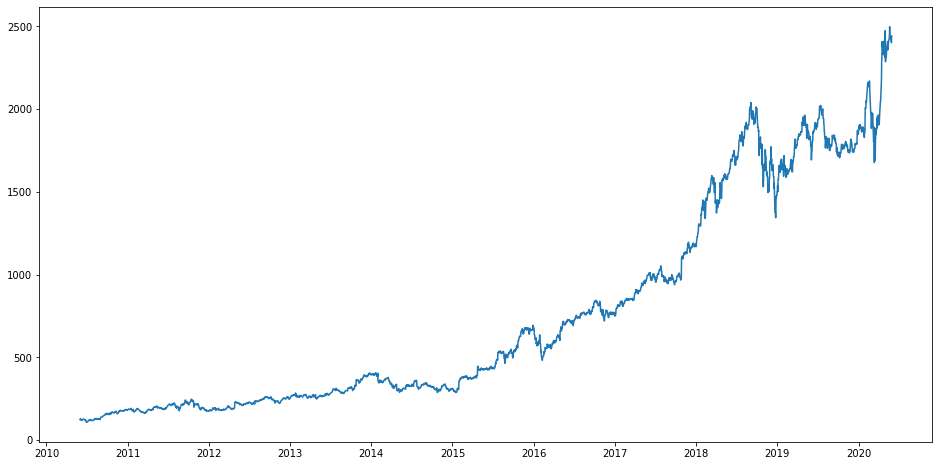

In [24]:
plt.figure(figsize=(16,8))
plt.plot(amazon_stock_prices['close_value'], label='Close Price history')

## Working on the combined dataset of stock prices and tweets

###Concatenation of the datasets stock_price and tweets

In [25]:
amazon_data = pd.concat([amazon_stock_prices, grouped_tweets], axis=1)
amazon_data.dropna(axis=0, inplace=True)

amazon_data

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,body
day_date,,,,,,,,
2015-01-01,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.0100,"A Value Stock, Or Neither? $AAPL $AMZN $FB $GO..."
2015-01-02,AMZN,2015-01-02,308.52,2785167,312.58,314.75,306.9601,"“Safety used to mean gold, US treasuries, and ..."
2015-01-03,AMZN,2015-01-03,308.52,2785167,312.58,314.75,306.9601,What to expect from Apple in 2015 beyond its s...
2015-01-04,AMZN,2015-01-04,308.52,2785167,312.58,314.75,306.9601,Bibliophiles Rejoice: BookBub Helps Readers Fi...
2015-01-05,AMZN,2015-01-05,302.19,2768215,307.01,308.38,300.8500,"Google, Yahoo! or Alibaba May Buy Takeover Tar..."
...,...,...,...,...,...,...,...,...
2019-12-27,AMZN,2019-12-27,1869.80,6188754,1882.92,1901.40,1866.0100,"Join us for Daily Powerful Watchlist, Swing & ..."
2019-12-28,AMZN,2019-12-28,1869.80,6188754,1882.92,1901.40,1866.0100,Past 10 years ...#1 $NFLX#2 $AMZN#3 $NVDA#4 $A...
2019-12-29,AMZN,2019-12-29,1869.80,6188754,1882.92,1901.40,1866.0100,SO VERY VERY CLOSE!. Market traders don't miss...


### Adding some useful columns for sentiment analysis of the tweets


In [26]:
amazon_data['compound'] = ''
amazon_data['negative'] = ''
amazon_data['neutral'] = ''
amazon_data['positive'] = ''
amazon_data

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,body,compound,negative,neutral,positive
day_date,,,,,,,,,,,,
2015-01-01,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.0100,"A Value Stock, Or Neither? $AAPL $AMZN $FB $GO...",,,,
2015-01-02,AMZN,2015-01-02,308.52,2785167,312.58,314.75,306.9601,"“Safety used to mean gold, US treasuries, and ...",,,,
2015-01-03,AMZN,2015-01-03,308.52,2785167,312.58,314.75,306.9601,What to expect from Apple in 2015 beyond its s...,,,,
2015-01-04,AMZN,2015-01-04,308.52,2785167,312.58,314.75,306.9601,Bibliophiles Rejoice: BookBub Helps Readers Fi...,,,,
2015-01-05,AMZN,2015-01-05,302.19,2768215,307.01,308.38,300.8500,"Google, Yahoo! or Alibaba May Buy Takeover Tar...",,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,AMZN,2019-12-27,1869.80,6188754,1882.92,1901.40,1866.0100,"Join us for Daily Powerful Watchlist, Swing & ...",,,,
2019-12-28,AMZN,2019-12-28,1869.80,6188754,1882.92,1901.40,1866.0100,Past 10 years ...#1 $NFLX#2 $AMZN#3 $NVDA#4 $A...,,,,
2019-12-29,AMZN,2019-12-29,1869.80,6188754,1882.92,1901.40,1866.0100,SO VERY VERY CLOSE!. Market traders don't miss...,,,,


### Sentiment analysis of the tweets using the nltk's built in Sentiment Analyzer

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

# amazon_data['compound'] = amazon_data['body'].apply(lambda x: sid.polarity_scores(x)['compound'])
# print('Compound Done')
amazon_data['negative'] = amazon_data['body'].apply(lambda x: sid.polarity_scores(x)['neg'])
print('Negative Done')
# amazon_data['neutral'] = amazon_data['body'].apply(lambda x: sid.polarity_scores(x)['neu'])
# print('Neutral Done')
amazon_data['positive'] = amazon_data['body'].apply(lambda x: sid.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

amazon_data

Start calculating sentiment scores:
Negative Done
Positive Done
Stop


,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value,body,compound,negative,neutral,positive
day_date,,,,,,,,,,,,
2015-01-01,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.0100,"A Value Stock, Or Neither? $AAPL $AMZN $FB $GO...",,0.107,,0.078
2015-01-02,AMZN,2015-01-02,308.52,2785167,312.58,314.75,306.9601,"“Safety used to mean gold, US treasuries, and ...",,0.039,,0.117
2015-01-03,AMZN,2015-01-03,308.52,2785167,312.58,314.75,306.9601,What to expect from Apple in 2015 beyond its s...,,0.096,,0.073
2015-01-04,AMZN,2015-01-04,308.52,2785167,312.58,314.75,306.9601,Bibliophiles Rejoice: BookBub Helps Readers Fi...,,0.016,,0.141
2015-01-05,AMZN,2015-01-05,302.19,2768215,307.01,308.38,300.8500,"Google, Yahoo! or Alibaba May Buy Takeover Tar...",,0.020,,0.078
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,AMZN,2019-12-27,1869.80,6188754,1882.92,1901.40,1866.0100,"Join us for Daily Powerful Watchlist, Swing & ...",,0.039,,0.137
2019-12-28,AMZN,2019-12-28,1869.80,6188754,1882.92,1901.40,1866.0100,Past 10 years ...#1 $NFLX#2 $AMZN#3 $NVDA#4 $A...,,0.027,,0.073
2019-12-29,AMZN,2019-12-29,1869.80,6188754,1882.92,1901.40,1866.0100,SO VERY VERY CLOSE!. Market traders don't miss...,,0.026,,0.084


### Reviewing the dataset for any null or false entries

In [28]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2015-01-01 to 2019-12-31
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ticker_symbol  1825 non-null   object        
 1   day_date       1825 non-null   datetime64[ns]
 2   close_value    1825 non-null   float64       
 3   volume         1825 non-null   int64         
 4   open_value     1825 non-null   float64       
 5   high_value     1825 non-null   float64       
 6   low_value      1825 non-null   float64       
 7   body           1825 non-null   object        
 8   compound       1825 non-null   object        
 9   negative       1825 non-null   float64       
 10  neutral        1825 non-null   object        
 11  positive       1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memory usage: 185.4+ KB


###Dropping out some unnecessary columns

In [29]:
amazon_data.drop(['body','ticker_symbol'], inplace=True, axis=1)
amazon_data = amazon_data[['day_date','close_value', 'compound', 'negative', 'neutral', 'positive', 'open_value', 'high_value', 'low_value', 'volume']]
amazon_data

,day_date,close_value,compound,negative,neutral,positive,open_value,high_value,low_value,volume
day_date,,,,,,,,,,
2015-01-01,2015-01-01,310.35,,0.107,,0.078,311.55,312.98,310.0100,2048676
2015-01-02,2015-01-02,308.52,,0.039,,0.117,312.58,314.75,306.9601,2785167
2015-01-03,2015-01-03,308.52,,0.096,,0.073,312.58,314.75,306.9601,2785167
2015-01-04,2015-01-04,308.52,,0.016,,0.141,312.58,314.75,306.9601,2785167
2015-01-05,2015-01-05,302.19,,0.020,,0.078,307.01,308.38,300.8500,2768215
...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019-12-27,1869.80,,0.039,,0.137,1882.92,1901.40,1866.0100,6188754
2019-12-28,2019-12-28,1869.80,,0.027,,0.073,1882.92,1901.40,1866.0100,6188754
2019-12-29,2019-12-29,1869.80,,0.026,,0.084,1882.92,1901.40,1866.0100,6188754


### Creating a new dataframe containing all the columns required to the model

In [30]:
# new_data = pd.DataFrame(index=range(0,len(amazon_data)),columns=['Date', 'Close','Open','High','Low','Volume','Compound'])
new_data = pd.DataFrame(index=range(0,len(amazon_data)),columns=['Date', 'Close','Negative','Positive','Volume','apple','tesla','microsoft','google'])
for i in range(0,len(amazon_data)):
    new_data['Date'][i] = amazon_data['day_date'][i]
    new_data['Close'][i] = amazon_data['close_value'][i]
    # new_data['Compound'][i] = amazon_data['compound'][i]
    new_data['Positive'][i] = amazon_data['positive'][i]
    new_data['Negative'][i] = amazon_data['negative'][i]
    # new_data['Open'][i] = amazon_data['open_value'][i]
    # new_data['High'][i] = amazon_data['high_value'][i]
    # new_data['Low'][i] = amazon_data['low_value'][i]
    new_data['Volume'][i] = amazon_data['volume'][i]
    new_data['apple'][i] = apple_data['close_value'][i]
    new_data['tesla'][i] = tesla_data['close_value'][i]
    new_data['microsoft'][i] = microsoft_data['close_value'][i]
    new_data['google'][i] = google_data['close_value'][i]

###Calculating the change in stock prices of other companies and making them as a parameter for the input
because the change in stock prices of other competitive companies might effect the stock price of amazon

In [31]:
new_data['apple_change']=''
new_data['tesla_change']=''
new_data['microsoft_change']=''
new_data['google_change']=''

In [32]:
for i in range(1,len(new_data)):
    new_data['apple_change'][i] = new_data['apple'][i]-new_data['apple'][i-1]
    new_data['tesla_change'][i] = new_data['tesla'][i]-new_data['tesla'][i-1]
    new_data['microsoft_change'][i] = new_data['microsoft'][i]-new_data['microsoft'][i-1]
    new_data['google_change'][i] = new_data['google'][i]-new_data['google'][i-1]
new_data['apple_change'][0] = new_data['apple_change'][1]
new_data['tesla_change'][0] = new_data['tesla_change'][1]
new_data['microsoft_change'][0] = new_data['microsoft_change'][1]
new_data['google_change'][0] = new_data['google_change'][1]

###Using the date as the index of the data

In [33]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
new_data.drop('apple', axis=1, inplace=True)
new_data.drop('tesla', axis=1, inplace=True)
new_data.drop('microsoft', axis=1, inplace=True)
new_data.drop('google', axis=1, inplace=True)
new_data

,Close,Negative,Positive,Volume,apple_change,tesla_change,microsoft_change,google_change
Date,,,,,,,,
2015-01-01,310.35,0.107,0.078,2048676,-1.05,-3.1,0.31,-1.59
2015-01-02,308.52,0.039,0.117,2785167,-1.05,-3.1,0.31,-1.59
2015-01-03,308.52,0.096,0.073,2785167,0,0,0,0
2015-01-04,308.52,0.016,0.141,2785167,0,0,0,0
2015-01-05,302.19,0.02,0.078,2768215,-3.08,-9.22,-0.435,-10.94
...,...,...,...,...,...,...,...,...
2019-12-27,1869.8,0.039,0.137,6188754,5.64,5.69,1.29,16.84
2019-12-28,1869.8,0.027,0.073,6188754,-0.11,-0.56,0.29,-8.51
2019-12-29,1869.8,0.026,0.084,6188754,0,0,0,0


###Preprocess data for training by removing all commas


In [34]:
cols = list(new_data)[0:8]
 
new_data = new_data[cols].astype(str)
for i in cols:
    for j in range(0,len(new_data)):
        new_data[i][j] = new_data[i][j].replace(",","")
 
new_data = new_data.astype(float)

In [35]:
dataset = new_data.to_numpy() 
dataset

array([[ 3.10350e+02,  1.07000e-01,  7.80000e-02, ..., -3.10000e+00,
         3.10000e-01, -1.59000e+00],
       [ 3.08520e+02,  3.90000e-02,  1.17000e-01, ..., -3.10000e+00,
         3.10000e-01, -1.59000e+00],
       [ 3.08520e+02,  9.60000e-02,  7.30000e-02, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       ...,
       [ 1.86980e+03,  2.60000e-02,  8.40000e-02, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 1.84689e+03,  4.30000e-02,  1.07000e-01, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 1.84784e+03,  3.30000e-02,  1.10000e-01, ..., -1.56800e+01,
        -1.37000e+00, -1.57500e+01]])

###Splitting the dataset into training and validation set



In [36]:
training_set = dataset[0:1600,:]
validation_set = dataset[1600:,:]

### Normalizing the columns of training set using MinMaxScaler from sklearn

In [37]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler()                     #MinMaxScaler object for the output column(will be used later in the prediction)
sc_predict.fit_transform(training_set[:,0:1])

array([[0.0133519 ],
       [0.01230771],
       [0.01230771],
       ...,
       [0.90270804],
       [0.90270804],
       [0.89698498]])

###Transforming the data into the format accepted by the model

In [38]:
X_train =[]
y_train = []

n_future = 7  # Number of days you want to predict into the future
n_past = 60  # Number of past days you want to use to predict the future
 
for i in range(n_past, len(training_set_scaled) - n_future + 1):
    X_train.append(training_set_scaled[i - n_past:i, :])
    y_train.append(training_set_scaled[i+n_future-1:i + n_future, 0])
 
X_train, y_train = np.array(X_train), np.array(y_train)
 
# for i in range (60,len(training_set_scaled)):
#     X_train.append(training_set_scaled[i-60:i, :])
#     y_train.append(training_set_scaled[i, 0])
# X_train, y_train = np.array(X_train) , np.array(y_train)

In [39]:
X_train

array([[[0.0133519 , 0.70394737, 0.3362069 , ..., 0.44746667,
         0.50472441, 0.50738891],
        [0.01230771, 0.25657895, 0.50431034, ..., 0.44746667,
         0.50472441, 0.50738891],
        [0.01230771, 0.63157895, 0.31465517, ..., 0.48053333,
         0.48031496, 0.5156624 ],
        ...,
        [0.05318506, 0.        , 0.23275862, ..., 0.43946667,
         0.46417323, 0.53085649],
        [0.05318506, 0.09210526, 0.08189655, ..., 0.48053333,
         0.48031496, 0.5156624 ],
        [0.05318506, 0.11842105, 0.125     , ..., 0.48053333,
         0.48031496, 0.5156624 ]],

       [[0.01230771, 0.25657895, 0.50431034, ..., 0.44746667,
         0.50472441, 0.50738891],
        [0.01230771, 0.63157895, 0.31465517, ..., 0.48053333,
         0.48031496, 0.5156624 ],
        [0.01230771, 0.10526316, 0.60775862, ..., 0.48053333,
         0.48031496, 0.5156624 ],
        ...,
        [0.05318506, 0.09210526, 0.08189655, ..., 0.48053333,
         0.48031496, 0.5156624 ],
        [0.0

### Creating the input for the model for validation

In [40]:
inputs = new_data[len(new_data) - len(validation_set) - n_past:].to_numpy() 
inputs

array([[ 1.76477e+03,  3.90000e-02,  9.20000e-02, ...,  4.20000e-01,
         2.70000e+00,  7.57000e+00],
       [ 1.76477e+03,  4.50000e-02,  6.10000e-02, ..., -9.49000e+00,
        -3.17000e+00, -2.60400e+01],
       [ 1.76477e+03,  6.60000e-02,  5.70000e-02, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       ...,
       [ 1.86980e+03,  2.60000e-02,  8.40000e-02, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 1.84689e+03,  4.30000e-02,  1.07000e-01, ...,  0.00000e+00,
         0.00000e+00,  0.00000e+00],
       [ 1.84784e+03,  3.30000e-02,  1.10000e-01, ..., -1.56800e+01,
        -1.37000e+00, -1.57500e+01]])

### Transforming the input into the format accepted by the model

In [41]:
inputs  = sc.transform(inputs)

X_test = []
y_test=[]
for i in range(n_past,len(inputs)-n_future+1):
    X_test.append(inputs[i-n_past:i,:])
    y_test.append(inputs[i+n_future-1:i + n_future, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

### Creating the sequential LSTM model using keras

In [42]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [68]:
model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(LSTM(units=128, return_sequences=True, input_shape=(n_past,3),kernel_regularizer='l2'))
model.add(LSTM(units=256, return_sequences=True, input_shape=(n_past,8)))
model.add(Dropout(rate = 0.1))
model.add(Dense(units=256))
model.add(LeakyReLU())
model.add(Dropout(rate = 0.1))
model.add(LSTM(units=128))
model.add(Dropout(rate = 0.1))
model.add(Dense(1,activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

In [69]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

### Training the model on our dataset

In [70]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')
 
history = model.fit(X_train, y_train, epochs=150,
                        callbacks=[es, rlr,mcp, tb],validation_data=(X_test, y_test), verbose=1, batch_size=1)

Epoch 1/150
1534/1534 [==============================] - 21s 12ms/step - loss: 0.0168 - val_loss: 0.0016

Epoch 00001: val_loss improved from inf to 0.00155, saving model to weights.h5
Epoch 2/150
1534/1534 [==============================] - 16s 11ms/step - loss: 0.0029 - val_loss: 0.0022

Epoch 00002: val_loss did not improve from 0.00155
Epoch 3/150
1534/1534 [==============================] - 17s 11ms/step - loss: 0.0023 - val_loss: 0.0017

Epoch 00003: val_loss did not improve from 0.00155
Epoch 4/150
1534/1534 [==============================] - 17s 11ms/step - loss: 0.0028 - val_loss: 0.0014

Epoch 00004: val_loss improved from 0.00155 to 0.00136, saving model to weights.h5
Epoch 5/150
1534/1534 [==============================] - 17s 11ms/step - loss: 0.0022 - val_loss: 0.0020

Epoch 00005: val_loss did not improve from 0.00136
Epoch 6/150
1534/1534 [==============================] - 17s 11ms/step - loss: 0.0022 - val_loss: 0.0011

Epoch 00006: val_loss improved from 0.00136 to 0.

### Using the model to predict the closing values of the stock price

In [71]:
predicted_price = model.predict(X_test)
predicted_price = sc_predict.inverse_transform(predicted_price)

In [72]:
predicted_price_train = model.predict(X_train)
predicted_price_train = sc_predict.inverse_transform(predicted_price_train)

### Calculating the root mean squared percentage error between the actual price and the predicted price

In [73]:
rmspe=np.sqrt(np.mean(np.square((sc_predict.inverse_transform(y_test) - predicted_price)/sc_predict.inverse_transform(y_test))))*100
rmspe

3.303534606553015

In [74]:
rmspe_train = np.sqrt(np.mean(np.square((sc_predict.inverse_transform(y_train.reshape(-1,1)) - predicted_price_train)/sc_predict.inverse_transform(y_train.reshape(-1,1)))))*100
rmspe_train

3.620937174861304

###Creating the dataframes of predicted prices and actual prices for the graph

In [75]:
valid = pd.DataFrame(index=range(1600+n_future-1,len(amazon_data)),columns=['Date', 'Close','Predictions'])
for i in range(1600+n_future-1,len(amazon_data)):
    valid['Date'][i] = amazon_data['day_date'][i]
    valid['Close'][i] = amazon_data['close_value'][i]
    valid['Predictions'][i] = predicted_price[i-(1600+n_future-1)][0]
valid.index = valid.Date
valid.drop('Date', axis=1, inplace=True)

train = pd.DataFrame(index=range(n_past+n_future-1,1600),columns=['Date', 'Close','Predictions'])
for i in range(n_past+n_future-1,1600):
    train['Date'][i] = amazon_data['day_date'][i]
    train['Close'][i] = amazon_data['close_value'][i]
    train['Predictions'][i] = predicted_price_train[i-(n_past+n_future-1)][0]
train.index = train.Date
train.drop('Date', axis=1, inplace=True)

In [83]:
train[100:106]

,Close,Predictions
Date,,
2015-06-17,427.81,438.374
2015-06-18,439.39,451.596
2015-06-19,434.92,443.914
2015-06-20,434.92,442.493
2015-06-21,434.92,440.816
2015-06-22,436.29,434.493


In [82]:
valid[38:44]

,Close,Predictions
Date,,
2019-07-04,1939,1916.07
2019-07-05,1942.91,1922.6
2019-07-06,1942.91,1943.36
2019-07-07,1942.91,1941.35
2019-07-08,1952.32,1953.02
2019-07-09,1988.3,1968.63


### Plotting the predicted prices and the actual prices on a graph

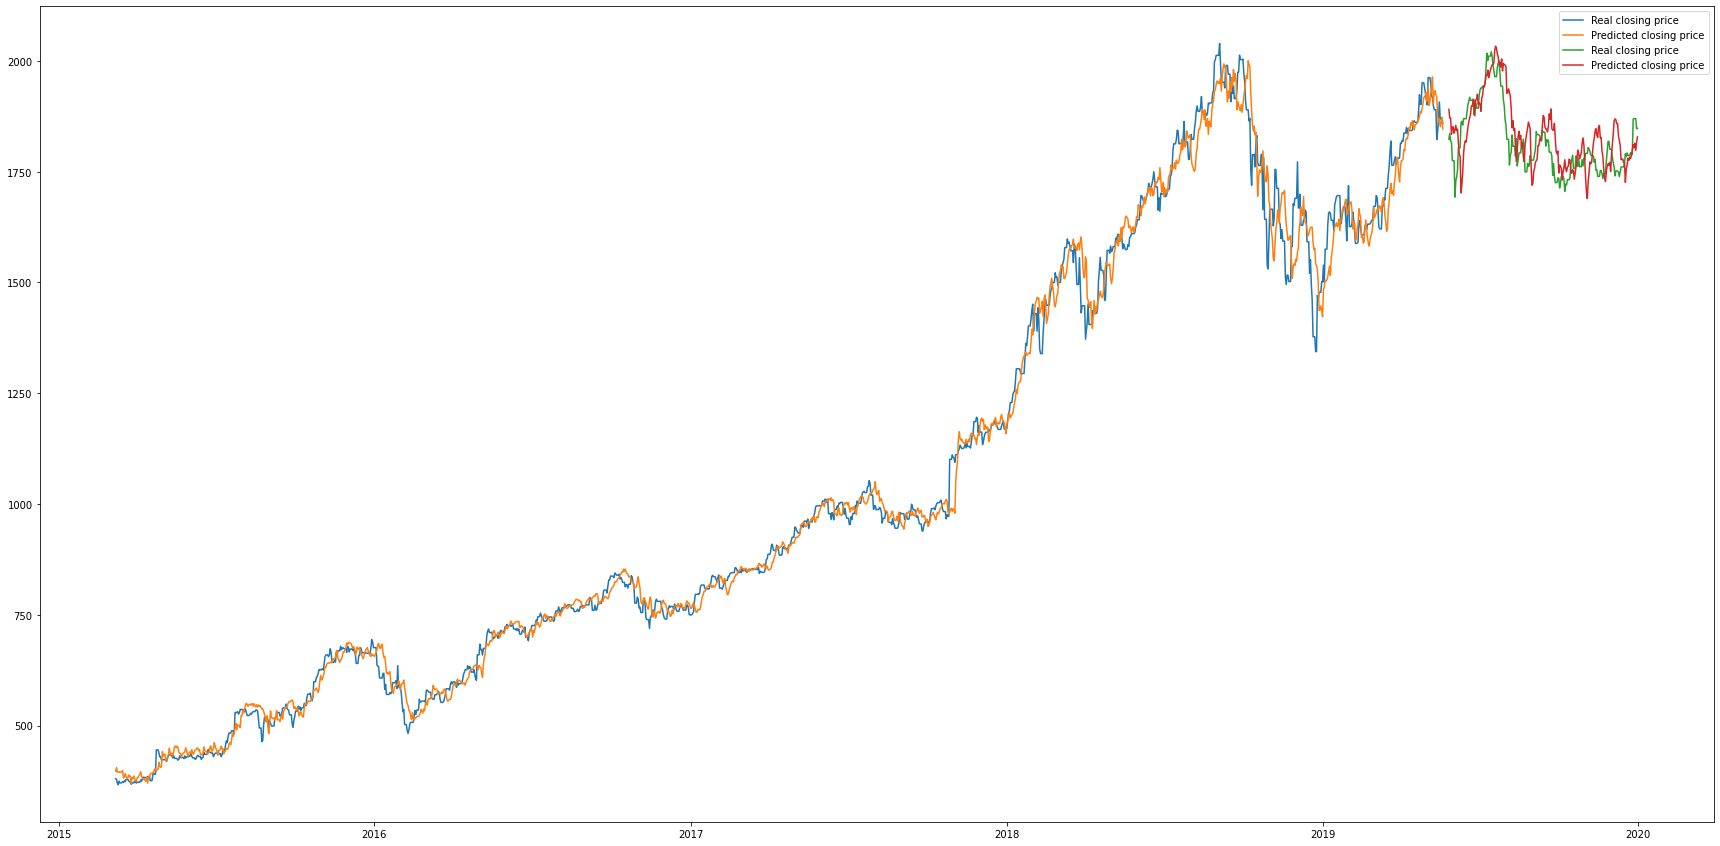

In [77]:
plt.figure(figsize=(30,15))
# plt.plot(train['Close'])
plt.plot(train['Close'],label='Real closing price')
plt.plot(train['Predictions'],label = 'Predicted closing price')
plt.plot(valid['Close'],label='Real closing price')
plt.plot(valid['Predictions'],label = 'Predicted closing price')
plt.legend()
plt.show()

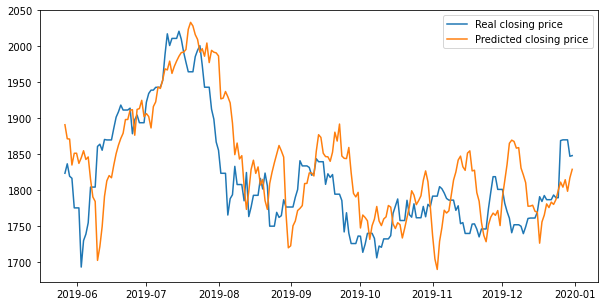

In [78]:
plt.figure(figsize=(10,5))
plt.plot(valid['Close'],label='Real closing price')
plt.plot(valid['Predictions'],label = 'Predicted closing price')
plt.legend()
plt.show()

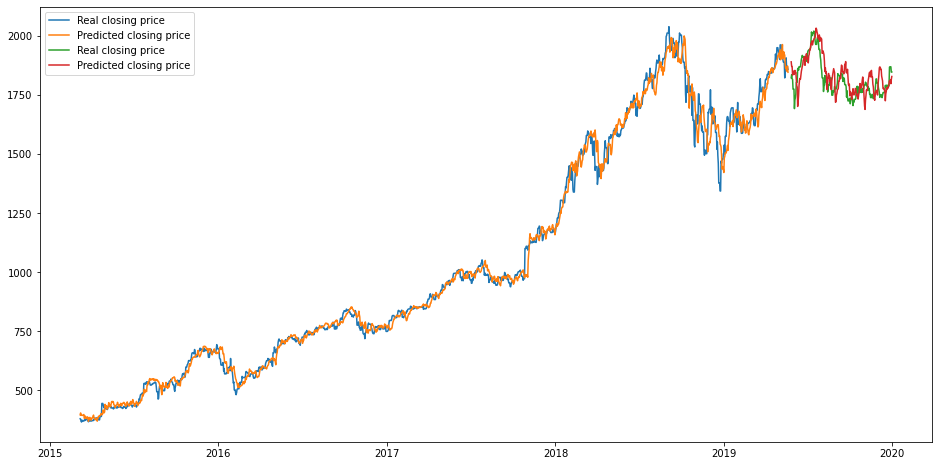

In [79]:
plt.figure(figsize=(16,8))
# plt.plot(train['Close'])
plt.plot(train['Close'],label='Real closing price')
plt.plot(train['Predictions'],label = 'Predicted closing price')
plt.plot(valid['Close'],label='Real closing price')
plt.plot(valid['Predictions'],label = 'Predicted closing price')
plt.legend()
plt.show()